In [ ]:
# Importing Libraries
import numpy as np
import pandas as pd 
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler 
from keras.models import Sequential 
from keras.layers import Dense, LSTM 
import math 
import seaborn as sb 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [ ]:
# Reading the dataset
data = pd.read_csv('https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv')
# Printing the first 5 rows of the dataset
data.head()


,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [ ]:
# Printing the last 5 rows of the dataset
data.tail()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56


In [ ]:
# Printing all the columns in the dataset
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Last', 'Close', 'Total Trade Quantity',
       'Turnover (Lacs)'],
      dtype='object')

In [ ]:
# Printing the shape of the dataset
data.shape

(2035, 8)

In [ ]:
# Printing the full summary of the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2035 entries, 0 to 2034
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  2035 non-null   object 
 1   Open                  2035 non-null   float64
 2   High                  2035 non-null   float64
 3   Low                   2035 non-null   float64
 4   Last                  2035 non-null   float64
 5   Close                 2035 non-null   float64
 6   Total Trade Quantity  2035 non-null   int64  
 7   Turnover (Lacs)       2035 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 127.3+ KB


In [ ]:
# Printing some basic statistical details of the dataframe
data.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


In [ ]:
# Checking missing values
data.isnull().sum()

Date                    0
Open                    0
High                    0
Low                     0
Last                    0
Close                   0
Total Trade Quantity    0
Turnover (Lacs)         0
dtype: int64

Text(0, 0.5, 'Close')

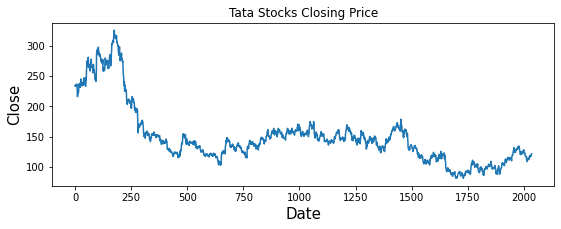

In [ ]:
plt.figure(figsize = (9,3))
plt.title('Tata Stocks Closing Price')
plt.plot(data['Close'])
plt.xlabel('Date',fontsize=15)
plt.ylabel('Close',fontsize=15)

In [ ]:
# Storing the target attribute in the 'Close' Column.
data_close = data.reset_index()['Close']
data_close.head()

0    233.75
1    233.25
2    234.25
3    236.10
4    233.30
Name: Close, dtype: float64

In [ ]:
# Using MinMaxScaler to scale down all the target variables in the range of (0, 1) for the ease of computation.
scaler = MinMaxScaler(feature_range = (0, 1))
data_close = scaler.fit_transform(np.array(data_close).reshape(-1, 1))
data_close

array([[0.62418301],
       [0.62214052],
       [0.62622549],
       ...,
       [0.1621732 ],
       [0.16319444],
       [0.16584967]])

In [ ]:
# Spliting our data into Training data (80%) and Testing data (20%)
train_size = int(len(data_close) * 0.80)
test_size = len(data_close) - train_size
train_data, test_data = data_close[0 : train_size, :], data_close[train_size : len(data_close), : 1]

In [ ]:
train_size,test_size

(1628, 407)

In [ ]:
train_data

array([[0.62418301],
       [0.62214052],
       [0.62622549],
       ...,
       [0.1435866 ],
       [0.13419118],
       [0.1431781 ]])

In [ ]:
# Linking the values of datasets
def create_dataset(dataset, time_step = 1):
  X_data, Y_data = [], []
  for i in range(len(dataset) - time_step - 1):
	  a = dataset[i : (i + time_step), 0] 
	  X_data.append(a)
	  Y_data.append(dataset[i + time_step, 0])
  return np.array(X_data), np.array(Y_data)

In [ ]:
# Fixing the step size value as 100
time_step = 100
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

In [ ]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(1527, 100) (1527,)
(306, 100) (306,)


In [ ]:
# Reshapping the X_train and X_test dataframe
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] , 1)

In [ ]:
# Creating the Stacked LSTM model
lst = Sequential()
lst.add(LSTM(50,return_sequences = True, input_shape = (100, 1)))
lst.add(LSTM(50, return_sequences = True))
lst.add(LSTM(50))
lst.add(Dense(1))
lst.compile(loss = 'mean_squared_error', optimizer='adam')

In [ ]:
lst.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lst.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
24/24 [==============================] - 9s 171ms/step - loss: 0.0180 - val_loss: 0.0049
Epoch 2/100
24/24 [==============================] - 3s 146ms/step - loss: 0.0021 - val_loss: 5.5271e-04
Epoch 3/100
24/24 [==============================] - 3s 130ms/step - loss: 0.0015 - val_loss: 8.8488e-04
Epoch 4/100
24/24 [==============================] - 3s 131ms/step - loss: 0.0013 - val_loss: 7.4638e-04
Epoch 5/100
24/24 [==============================] - 3s 127ms/step - loss: 0.0013 - val_loss: 6.4380e-04
Epoch 6/100
24/24 [==============================] - 3s 130ms/step - loss: 0.0012 - val_loss: 5.7183e-04
Epoch 7/100
24/24 [==============================] - 3s 130ms/step - loss: 0.0011 - val_loss: 8.1178e-04
Epoch 8/100
24/24 [==============================] - 3s 129ms/step - loss: 0.0010 - val_loss: 5.7375e-04
Epoch 9/100
24/24 [==============================] - 3s 128ms/step - loss: 0.0010 - val_loss: 4.9753e-04
Epoch 10/100
24/24 [==============================] - 3s 12

In [ ]:
# Prediction
train_predict = lst.predict(X_train)
test_predict = lst.predict(X_test)

In [ ]:
# Reversing the MinMax Scaler
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
# Trained Data RMSE
math.sqrt(mean_squared_error(Y_train, train_predict))

160.82659811977263

In [ ]:
# Tested Data RMSE
math.sqrt(mean_squared_error(Y_test,test_predict))

107.18640198600517

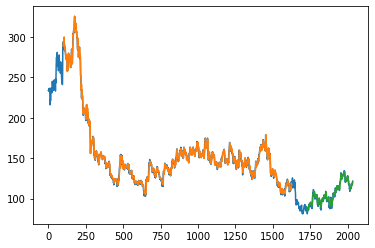

In [ ]:
# Plotting the Predictions
look_back = 100
train_num_pyredict_plot = np.empty_like(data_close)
train_num_pyredict_plot[:, :] = np.nan
train_num_pyredict_plot[look_back : len(train_predict) + look_back, :] = train_predict
test_predict_plot = np.empty_like(data_close)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (look_back * 2) + 1 : len(data_close) - 1, :] = test_predict
plt.plot(scaler.inverse_transform(data_close))
plt.plot(train_num_pyredict_plot)
plt.plot(test_predict_plot)
plt.show()

In [ ]:
# Future Prediction
x_inum_pyut=test_data[307:].reshape(1, -1)
x_inum_pyut.shape
temp_inum_pyut = list(x_inum_pyut)
temp_inum_pyut = temp_inum_pyut[0].tolist()
temp_inum_pyut = list(x_inum_pyut)
temp_inum_pyut = temp_inum_pyut[0].tolist()

In [ ]:
day_new = np.arange(1, 101)
day_pred = np.arange(101, 131)

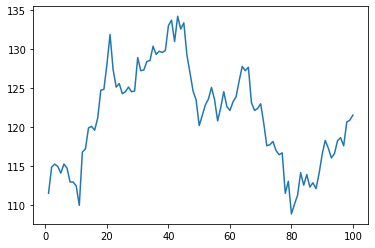

In [ ]:
plt.plot(day_new, scaler.inverse_transform(data_close[1935 : ]))

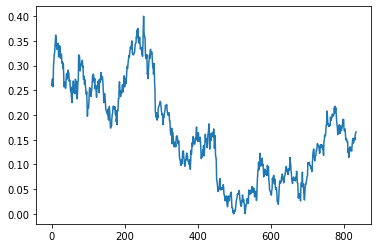

In [ ]:
data_merge = data_close.tolist()
plt.plot(data_merge[1200 : ])